In [1]:
!pip3 install --upgrade ibm-generative-ai


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip3 install genai


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
# %capture --no-stderr
%pip install -U langchain-nomic langchain_community tiktoken langchainhub chromadb langchain langgraph 

  Using cached tiktoken-0.7.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.6 kB)
Using cached tiktoken-0.7.0-cp311-cp311-macosx_11_0_arm64.whl (907 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.1/87.1 kB 868.4 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: tiktoken
    Found existing installation: tiktoken 0.3.3
    Uninstalling tiktoken-0.3.3:
      Successfully uninstalled tiktoken-0.3.3
  Attempting uninstall: langgraph
    Found existing installation: langgraph 0.2.5
    Uninstalling langgraph-0.2.5:
      Successfully uninstalled langgraph-0.2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-openai 0.1.22 requires openai<2.0.0,>=1.40.0, but you have openai 0.27.10 which is incompatible.
ragas 0.1.14 requires openai>1, but you have openai 0.27.10 which is incompatible.
llama-index-core 0.10.58 requires openai>=1.1.0, but you have openai 

In [3]:
import warnings, os
warnings.filterwarnings("ignore")
from langchain_ibm import WatsonxLLM
from dotenv import load_dotenv
# load_dotenv(override=True)

from genai import Client, Credentials

from genai.extensions.langchain import LangChainInterface
from genai.schema import (
    DecodingMethod,
    TextGenerationParameters,
)
# from langchain_ibm import WatsonxLLM
# from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams

def bam_model(model_id='meta-llama/llama-3-8b-instruct', decoding_method='greedy', max_new_tokens=1000, 
              min_new_tokens=1, temperature=0.5, top_k=50, top_p=1, repetition_penalty=1):

    credentials = Credentials(api_key="pak-6TdyOvhiJer2r777pkfGALfQe3O_IPtmJFl1Rp1DVBI", api_endpoint="https://bam-api.res.ibm.com" )
    if decoding_method == 'greedy':
        decoding_method = DecodingMethod.GREEDY
        parameters=TextGenerationParameters(
            decoding_method=decoding_method,
            max_new_tokens=max_new_tokens,
            min_new_tokens=min_new_tokens,
            repetition_penalty=repetition_penalty
        )
    else:
        decoding_method = DecodingMethod.SAMPLE
        parameters=TextGenerationParameters(
            decoding_method=decoding_method,
            max_new_tokens=max_new_tokens,
            min_new_tokens=min_new_tokens,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            repetition_penalty=repetition_penalty
        )

    llm = LangChainInterface(
        model_id=model_id,
        client=Client(credentials=credentials),
        parameters=parameters,
    )
#     parameters = {
#     "decoding_method": "sample",
#     "max_new_tokens": 100,
#     "min_new_tokens": 1,
#     "temperature": 0.5,
#     "top_k": 50,
#     "top_p": 1,
# }
#     load_dotenv()
#     api_key = os.getenv("api_key", None)
#     ibm_cloud_url = os.getenv("ibm_cloud_url", None)
#     project_id = os.getenv("project_id", None)
#     if api_key is None or ibm_cloud_url is None or project_id is None:
#         print("Ensure you copied the .env file that you created earlier into the same directory as this notebook")
#     else:
#         creds = {
#         "url": ibm_cloud_url,
#         "apikey": api_key 
#     }
    
#     llm = WatsonxLLM(
#     model_id=model_id,
#     url=ibm_cloud_url,
#     apikey=api_key,
#     project_id=project_id,
#     params=parameters,
# )
    return llm


In [4]:
local_llm = bam_model()
# print(local_llm.invoke(prompt))


# local_llm = "llama3"
model_tested = "meta-llama/llama-3-8b-instruct"
metadata = f"Self-RAG, {model_tested}"

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings, HuggingFaceBgeEmbeddings

# Load
# urls = [
#     "https://lilianweng.github.io/posts/2023-06-23-agent/",
#     "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
#     "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
# ]
# docs = [WebBaseLoader(url).load() for url in urls]
# docs_list = [item for sublist in docs for item in sublist]

# Split
# text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
#     chunk_size=500, chunk_overlap=100
# )
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyMuPDFLoader
loader_mu = PyMuPDFLoader("/Users/deekshas/Documents/selfRAG_v1/RFP_for_Support_Center_and_Staffing_04232024.pdf")
pages = loader_mu.load()
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=800,
    chunk_overlap=60
)
docs_split = text_splitter.split_documents(pages)
# docs = [doc.page_content for doc in docs_split]
# doc_splits = text_splitter.split_documents(docs_list)

# Embed and index
embedding = HuggingFaceBgeEmbeddings()

# Index
vectorstore = Chroma.from_documents(
    documents=docs_split,
    collection_name="rag-chroma",
    embedding=embedding,
)
retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
### Retrieval Grader

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

os.environ['TOKENIZERS_PARALLELISM']='true'

# LLM
llm = local_llm  #ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are a grader assessing relevance of a retrieved document to a user question. \n 
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "watsonx challenge"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

{'score': 'no'}


In [7]:
#Query Decomposition
from langchain_core.output_parsers import StrOutputParser
import ast
import re
class ListOutputParser(StrOutputParser):
    def parse(self, output: str):
        # Clean the output to extract the Python list within the ###
        # Extract only the portion of the text that matches the list format
        list_match = re.search(r'\[.*\]', output, re.DOTALL)
        if not list_match:
            raise ValueError(f"Output does not contain a valid list: {output}")

        list_str = list_match.group(0)
        # Replace single quotes with double quotes to maintain consistency
        #list_str = list_str.replace("'", '"')
        

        try:
            # Safely evaluate the extracted list string to a Python list
            sub_queries = ast.literal_eval(list_str)
            if isinstance(sub_queries, list):
                return sub_queries
            else:
                raise ValueError("Extracted content is not a list")
        except (SyntaxError, ValueError) as e:
            raise ValueError(f"Failed to parse list: {list_str}") from e


sub_query_prompt = PromptTemplate(
    template="""system
You are an advanced AI specializing in natural language processing and query understanding.
Your task is to analyze the user's query and determine whether it is simple or complex.
A 'simple' query focuses on a specific element (intent) and pertains to a single subject.
A 'complex' query involves multiple elements (intents) and/or multiple subjects.
Using the query, the context needs to be retrieved from a database to answer the query.
If the query is complex i.e. there are multiple informations that needs to be extracted, then break it down to multiple simpler queries.
If it is a simple query, return it as is.
The final output should be formatted as a Python list like this - ["subquery1", "subquery2", "subquery3"].Return only the list. 


User Query:
{query}
assistant
Output:""",
    input_variables=["query"],
)

# Create the LLMChain
query_decomposer = sub_query_prompt | llm | ListOutputParser()
a=query_decomposer.invoke({"query": "Identify the key contacts listed in the RFP by extracting contact information for key personnel or points of contact mentioned in the RFP"})
print(a)

['What are the key contacts listed in the RFP?', 'Who are the key personnel mentioned in the RFP?', 'What are the points of contact mentioned in the RFP?']


In [8]:
### Generate

from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 

    Use three sentences maximum and keep the answer concise.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {question} 
    Documents: {documents} 
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    Answer: 
    """,
    input_variables=["question", "documents"],
)

# LLM
llm = local_llm #ChatOllama(model=local_llm, temperature=0)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"documents": docs, "question": question})
print(generation)

 The Watsonx Challenge is not mentioned in the provided documents.


In [9]:
### Hallucination Grader

# LLM
llm = local_llm  #ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are a grader assessing whether an answer is grounded in / supported by a set of facts. \n 
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    Here is the answer: {generation}
    Give a binary score 'yes' or 'no' score to indicate whether the answer is grounded in / supported by a set of facts. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})

{'score': 'yes'}

In [10]:
### Answer Grader

# LLM
llm = local_llm  #ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are a grader assessing whether an answer is useful to resolve a question. \n 
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the question: {question}
    Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question, "generation": generation})

{'score': 'no'}

In [11]:
### Question Re-writer

# LLM
llm = local_llm  #ChatOllama(model=local_llm, temperature=0)

# Prompt
re_write_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You a question re-writer that converts an input question to a better version that is optimized \n 
    for vectorstore retrieval. Look at the initial and formulate an improved question. \n
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the initial question: {question}
    provide an improved question with no preamble or explanation: \n 
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"],
)

question_rewriter = re_write_prompt | llm | StrOutputParser()   
question_rewriter.invoke({"question": question})

'\n\nWhat is the Watson X challenge?'

In [12]:
from langchain.prompts import PromptTemplate
ANSWER_COMPLETENESS_PROMPT_LLAMA3 = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an evaluation system tasked with assessing the completeness of a chatbot's response in relation to the posed question. Define the completeness of answers as:
    - Complete: The answer comprehensively addresses all parts of the question.
    - Mostly Complete: The answer addresses most parts of the question but may omit some details that could provide a fuller understanding.
    - Partially Complete: The answer addresses only some parts of the question, leaving significant aspects unanswered or vaguely covered.
    - Incomplete: The answer does not effectively address the question posed or is mostly irrelevant to what was asked.
    Assess the completeness of the answer and provide the completeness level as a JSON object with two keys: 'completeness_level' and 'reasoning'.
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the question:
        -------
    {question}
        -------
    Here is the answer: {answer} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "answer"],
)
eval_chain = ANSWER_COMPLETENESS_PROMPT_LLAMA3|llm
eval_chain.invoke({"question":"Describe the size, scope, and complexity of the requirements by extracting information about the project‚Äôs scale, scope, and complexity as outlined in the RFP.","answer":"The project's scope is to explain the overall design process for all aspects of the system, covering the design process for all aspects of the enterprise. The scale of the project is not explicitly mentioned in the provided documents, but it appears to be a comprehensive design document. The scope of the project is to cover the overall design process for all aspects of the system. This includes the design of the system idea, its purpose, and the overall design of the project."})


'\n\nHere is the assessment of the completeness of the answer:\n\n{\n"completeness_level": "Mostly Complete",\n"reasoning": "The answer provides a good overview of the project\'s scope, which is a significant part of the question. It also mentions the scale of the project, but only notes that it is not explicitly mentioned in the provided documents, which is a partial answer. The complexity of the project is not addressed at all in the answer. Overall, the answer provides a good foundation, but leaves some important aspects unanswered."\n}\n\nThe answer is mostly complete because it provides a clear description of the project\'s scope, which is a key aspect of the question. However, it is not complete because it does not provide a clear description of the project\'s scale and complexity, which are also important aspects of the question. Additionally, the answer could be more detailed and specific in its description of the project\'s scope.'

In [35]:
from langchain.prompts import PromptTemplate
ANSWER_COMPLETENESS_PROMPT_LLAMA3 = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an evaluation system tasked with assessing the completeness of a chatbot's response in relation to the posed question. Define the completeness of answers as:
    - Complete: Assign score as 1
    - Mostly Complete: Assign score as 0.75
    - Partially Complete: Assign score as 0.5
    - Incomplete: Assign score as 0
    Assess the completeness of the answer and return only the completeness score as a JSON object with two keys: 'completeness_level' and 'reasoning'.
    Return only the JSON.
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the question:
        -------
    {question}
        -------
    Here is the answer: {answer} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "answer"],
)
eval_chain = ANSWER_COMPLETENESS_PROMPT_LLAMA3|llm
d=eval_chain.invoke({"question":"Describe the size, scope, and complexity of the requirements by extracting information about the project‚Äôs scale, scope, and complexity as outlined in the RFP.","answer":"The project's scope is to explain the overall design process for all aspects of the system, covering the design process for all aspects of the enterprise. The scale of the project is not explicitly mentioned in the provided documents, but it appears to be a comprehensive design document. The scope of the project is to cover the overall design process for all aspects of the system. This includes the design of the system idea, its purpose, and the overall design of the project."})


In [29]:
d=d.strip()
# print(d)
import json
data=json.loads(d)
print(data["completeness_level"])

0.75


In [38]:
import pandas as pd
import json
from tqdm import tqdm
file=pd.read_csv("/Users/deekshas/Documents/selfRAG_v1/result3.csv")
answer_completeness=[]
answer_reason=[]
for i in tqdm(range(0, len(file)), desc="Processing...", position=0):
    question = file.loc[i, "question"][:].strip()
    answer = file.loc[i, "answer"][:].strip()
    res=eval_chain.invoke({"question":question,"answer":answer})
    res=res.strip()
    print(res)
    data=json.loads(res)
    answer_completeness.append(data["completeness_level"])
    answer_reason.append(data["reasoning"])

file["Answer_Completeness"] = answer_completeness
file["Answer_Completeness_Reason"] = answer_reason
file.to_csv("/Users/deekshas/Documents/selfRAG_v1/result3.csv", index=False)

Processing...:   5%|▍         | 1/21 [00:02<00:52,  2.63s/it]

{
  "completeness_level": 0.75,
  "reasoning": "The answer provides a good summary of the RFP requirements, including the customer's name, purpose of the RFP, deadlines, fines or penalties, compliance, references, legal requirements, minority companies, small business requirements, and contact information. However, it does not provide a concise summary of the RFP, and some information is not explicitly highlighted, such as the project description and tasks to be accomplished."
}


Processing...:  10%|▉         | 2/21 [00:04<00:44,  2.33s/it]

{
    "completeness_level": 0,
    "reasoning": "The answer is 'Unanswerable', which means the chatbot did not attempt to provide any information or analysis to identify the customer's top priorities and pain points, making it an incomplete response."
}


Processing...:  14%|█▍        | 3/21 [00:06<00:40,  2.25s/it]

{
  "completeness_level": 0.75,
  "reasoning": "The answer provides a good description of the project's scope, but does not explicitly mention the scale or complexity of the project. It also does not provide specific details about the design process or the enterprise's requirements, which are important aspects of the project's requirements."
}


Processing...:  19%|█▉        | 4/21 [00:09<00:41,  2.41s/it]

{
  "completeness_level": 1,
  "reasoning": "The answer fully addresses the question by identifying specific requirements that may pose a risk to operations, including transition of services, schedule for start-up, and technical requirements. It also mentions several risks and challenges mentioned in the RFP, such as disaster recovery plan, plan for managing and implementing services, and quality assurance methods. The answer provides a detailed description of each requirement and its potential impact on the project or proposal."
}


Processing...:  24%|██▍       | 5/21 [00:12<00:42,  2.66s/it]

{
    "completeness_level": 0.75,
    "reasoning": "The answer identifies unclear requirements in the RFP, specifically related to job categories and qualifications of personnel. However, it does not provide questions to gather more details about the requirements, which is a key aspect of the original question."
}


Processing...:  29%|██▊       | 6/21 [00:15<00:39,  2.64s/it]

{
    "completeness_level": 0.75,
    "reasoning": "The answer provides most of the necessary information about the evaluation criteria, including the specific criteria and their relative weights. However, it does not provide a clear explanation of what is meant by 'responsiveness' and 'acceptability of the proposed system', which are important aspects of the evaluation criteria."
}


Processing...:  33%|███▎      | 7/21 [00:17<00:36,  2.60s/it]

{
  "completeness_level": 0.75,
  "reasoning": "The answer provides most of the required information, including specific compliance requirements mentioned in the RFP, such as notifying the project manager, executing non-disclosure agreements, and possessing required licenses and certifications. However, it does not mention any other specific compliance or certification requirements mentioned in the RFP, which is a minor omission."
}


Processing...:  38%|███▊      | 8/21 [00:20<00:33,  2.60s/it]

{
    "completeness_level": 0.75,
    "reasoning": "The answer provides most of the requested information, including budget constraints, pricing structures, and financial details. However, it does not explicitly mention the total budget or price range for the project, which is a key piece of information. The answer does provide some financial details, such as the estimated value of each contract and the fee structure, but it does not provide a comprehensive overview of the budget and price information."
}


Processing...:  43%|████▎     | 9/21 [00:22<00:29,  2.49s/it]

{
  "completeness_level": 1,
  "reasoning": "The answer provides a detailed and accurate description of the submission requirements, including deadlines, required formats, and supporting documents needed for proposal submission. The answer covers all aspects of the question, including the Technical Envelope Questionnaire tab, the RFx Technical Proposal section, and the required formats for proposal submission."
}


Processing...:  48%|████▊     | 10/21 [00:25<00:26,  2.45s/it]

{
  "completeness_level": 0.75,
  "reasoning": "The answer provides a good overview of the contract terms and conditions outlined in the RFP, including details about pricing information, M/WBE requirements, and personnel qualifications. However, it does not fully describe the legal terms and conditions, and some details are repeated. Additionally, it does not provide a comprehensive summary of all the contract terms and conditions outlined in the RFP."
}


Processing...:  52%|█████▏    | 11/21 [00:27<00:24,  2.48s/it]

{
  "completeness_level": 1,
  "reasoning": "The answer provides a clear and detailed description of appendices and attachments in the context of a Request for Proposal (RFP), including their purpose, types, and content. The answer also explains how they provide additional context or requirements, and provides specific examples of the types of documents that may be included."
}


Processing...:  57%|█████▋    | 12/21 [00:29<00:21,  2.36s/it]

{
    "completeness_level": 0.75,
    "reasoning": "The answer partially addresses the question by identifying the tone of the RFP as formal and professional, but does not explicitly assess the language and tone to identify specific preferences or expectations of the customer regarding how proposals should be written and presented."
}


Processing...:  62%|██████▏   | 13/21 [00:31<00:18,  2.26s/it]

{
  "completeness_level": 0.5,
  "reasoning": "The answer partially addresses the question by providing information about the RFP requirements, but does not analyze the requirements to identify potential competitors, their strengths, and weaknesses as requested."
}


Processing...:  67%|██████▋   | 14/21 [00:33<00:15,  2.22s/it]

{
  "completeness_level": 0.75,
  "reasoning": "The answer provides the key points of contact mentioned in the RFP, including name, title, telephone number, and e-mail address. However, it does not explicitly mention the key personnel, which is also mentioned in the question. Therefore, the answer is mostly complete."
}


Processing...:  71%|███████▏  | 15/21 [00:35<00:12,  2.14s/it]

{
  "completeness_level": 0.75,
  "reasoning": "The answer partially addresses the question by providing information about on-site services, but does not explicitly define where services should be delivered (nearshore, on-site, etc.) as requested."
}


Processing...:  76%|███████▌  | 16/21 [00:37<00:10,  2.14s/it]

{
  "completeness_level": 0.75,
  "reasoning": "The answer provides a list of documents that should be submitted with a proposal, but it does not explicitly state that there is a comprehensive list of documents. The answer only provides a few examples of documents that are typically required, but it does not provide a complete list."
}


Processing...:  81%|████████  | 17/21 [00:40<00:08,  2.18s/it]

{
    "completeness_level": 0.75,
    "reasoning": "The answer is mostly complete as it provides the technical factors that will be used to evaluate the suppliers, but it does not mention the commercial factors that will be used. It also does not provide the specific details of the evaluation criteria, such as the weightage of each factor."
}


Processing...:  86%|████████▌ | 18/21 [00:42<00:06,  2.17s/it]

{
  "completeness_level": 0.75,
  "reasoning": "The answer provides information about the current service provider's competencies, specifically mentioning the qualifications and responsibilities of the Level 1 Helpdesk Analysts. However, it does not mention the current service provider's weaknesses, which is a key aspect of the question."
}


Processing...:  90%|█████████ | 19/21 [00:44<00:04,  2.07s/it]

{
    "completeness_level": 0,
    "reasoning": "The answer is 'Unanswerable', which means the chatbot did not attempt to provide any information or answer the question, making it incomplete."
}


Processing...:  95%|█████████▌| 20/21 [00:45<00:01,  1.98s/it]

{
  "completeness_level": 0,
  "reasoning": "The answer is 'Unanswerable', which means the chatbot did not attempt to provide any information or answer the question, making it incomplete."
}


Processing...: 100%|██████████| 21/21 [00:47<00:00,  2.28s/it]

{
  "completeness_level": 0.75,
  "reasoning": "The answer partially addresses the question by providing information about the specified profile for resources, including certifications or defined years of experience. However, it does not explicitly state whether there is a defined quantity of resources for service delivery."
}


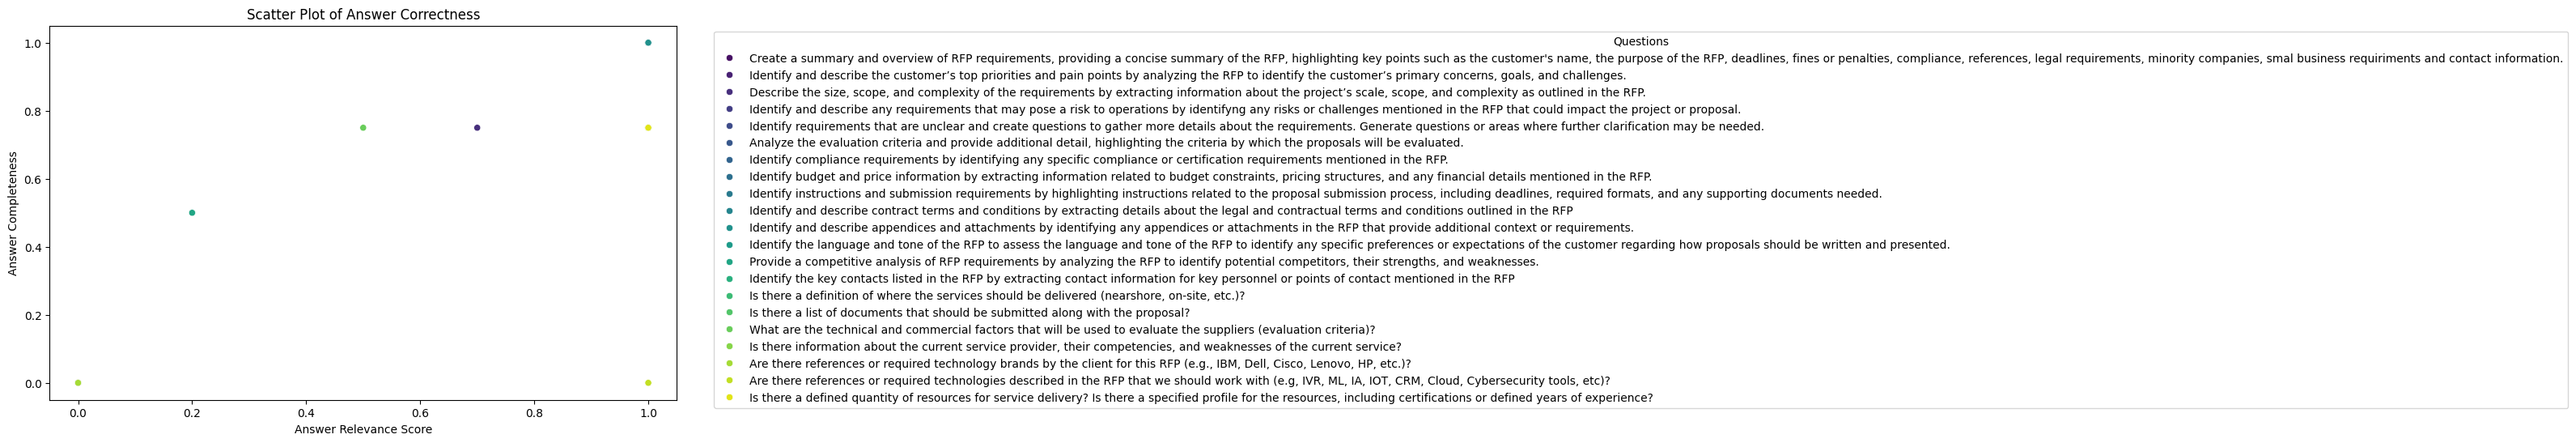

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data from the Excel file


# Scatter plot for Answer Correctness
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Answer_Relevance_Score", y="Answer_Completeness", hue="question", data=file, palette="viridis")

# Customize the plot
plt.title("Scatter Plot of Answer Correctness")
plt.xlabel("Answer Relevance Score")
plt.ylabel("Answer Completeness")
plt.legend(title="Questions", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()


In [43]:
!pip3 install openpyxl

  Using cached et_xmlfile-1.1.0-py3-none-any.whl.metadata (1.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 2.7 MB/s eta 0:00:00a 0:00:01
Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [19]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [44]:
### Nodes


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    print("--DOCS--")
    for doc in documents:
        print(doc.page_content)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"documents": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def query_decomposition(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    print("!!!!!!!")
    print(state)
    # documents = state["documents"]

    # # Re-write question
    # better_question = question_rewriter.invoke({"question": question})
    # return {"documents": documents, "question": better_question}
    subqueries = query_decomposer.invoke(question)  
    return {"subqueries": subqueries}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

### Edges
def combine_results(state):
    return "hi back"

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score["score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

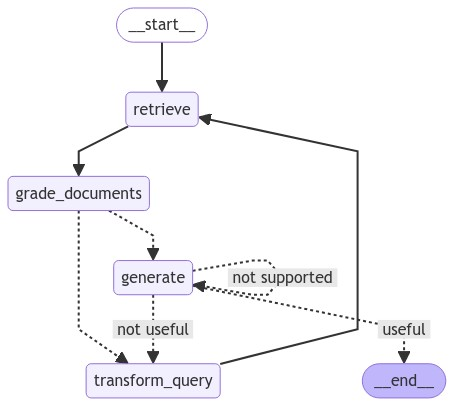

In [36]:
from langgraph.graph import END, StateGraph, START
from IPython.display import Image, display

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [39]:
from pprint import pprint

# Run
inputs = {"question": "Is there a defined quantity of resources for service delivery? Is there a specified profile for the resources, including certifications or defined years of experience?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    print("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
--DOCS--
39 
 
described herein.  The Proposer should site specific examples of services provided for 
projects of similar scope and complexity. 
 
f) Specific descriptions of methodologies for meeting the requirements to include project 
management and control procedures, client communications procedures, project 
scheduling and reporting procedures, and detailed descriptions of the workflow 
methodologies to be employed from the implementation of services.  Areas to be 
addressed include:  Help Desk Services, HDMS Administration. 
 
ii. 
Describe and demonstrate procedures for the review of qualifications and background check 
of personnel for the provision of services to meet the project requirements.
"Node 'retrieve':"

---

---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_doc

In [39]:
print(value["generation"])

 Yes, there is a defined quantity of resources for service delivery. Specifically, Level 1 Helpdesk Analysts shall have at least one year of experience working in a help desk environment as a helpdesk technician/analyst.


In [76]:
import uuid
#SEQUENTIAL

def predict_custom_agent_local_answer(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}, 
              "recursion_limit": 10  # Set the recursion limit here
              }
    question=example["input"]
    subqueries = query_decomposer.invoke(question)  
    result=""
    for subquery in subqueries:
        print("SUBQUERY")
        print(subquery)
        try:
            state_dict = app.invoke(
            {"question": subquery}, config
            )
            result+=state_dict["generation"]
        except Exception as e:
        # Catch any other exceptions and return a fallback response
            result+=""
    if len(result)==0:
        result="Unanswerable"
    return result

example = {"input": "Identify and describe the customer’s top priorities and pain points by analyzing the RFP to identify the customer’s primary concerns, goals, and challenges."}
response = predict_custom_agent_local_answer(example)
print(response)

SUBQUERY
What are the customer's top priorities?
---RETRIEVE---
--DOCS--
10 
 
 
b. Customer Service Center  
i. One (1) Customer Service Center Supervisor  
ii. One (1) Customer Service Center Agent 
 
c. Data Support Services 
i. 
Two (2) Data Base 
 
d. Desktop Support Services 
 
Presently the Desktop Support Services (DSS) group utilizes escalation and prioritization techniques 
based on service level agreements and priority user groups/individuals. Service requests are 
evaluated and assigned by the helpdesk analyst. The helpdesk currently uses ServiceNow This 
product is an appropriate tool for the dispatching and support of Headquarters and Field 
requirements. It possesses the ability to effectively track calls from inception to closure.  
 
e. Inventory Group
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECI

In [88]:
#PARALLEL 
import uuid
from concurrent.futures import ThreadPoolExecutor, as_completed

def predict_custom_agent_local_answer(example: dict):
    config = {
        "configurable": {"thread_id": str(uuid.uuid4())},
        "recursion_limit": 25  # Set the recursion limit here
    }
    question = example["input"]
    subqueries = query_decomposer.invoke(question)
    results = []

    # Define a helper function to call the graph
    def call_graph(subquery):
        try:
            state_dict = app.invoke({"question": subquery}, config)
            return state_dict.get("generation", "")
        except Exception as e:
            return ""  # Fallback response on error

    # Use ThreadPoolExecutor to run subqueries in parallel
    with ThreadPoolExecutor(max_workers=len(subqueries)) as executor:
        future_to_subquery = {executor.submit(call_graph, subquery): subquery for subquery in subqueries}

        for future in as_completed(future_to_subquery):
            subquery = future_to_subquery[future]
            try:
                result = future.result()
                results.append(result)
            except Exception as exc:
                print(f"Subquery {subquery} generated an exception: {exc}")
                results.append("")

    # Combine results or set to 'Unanswerable' if all are empty
    final_result = "".join(results) if any(results) else "Unanswerable"
    return final_result

example = {
    "input": "Create a summary and overview of RFP requirements, providing a concise summary of the RFP, highlighting key points such as the customer’s name, the purpose of the RFP, deadlines, fines or penalties, compliance, references, legal requirements, minority companies, smal business requiriments and contact information."
}
response = predict_custom_agent_local_answer(example)
print(response)


---RETRIEVE---
---RETRIEVE---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---CHECK HALLUCINATIONS---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GEN

In [24]:
example = {"input": "When is next ce only all hands meet"}
response = predict_custom_agent_local_answer(example)
print(response)

SUBQUERY
When is the next CE only all hands meeting?
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
---TRANSFORM QUERY---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
---TRANSFORM QUERY---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM 

In [1]:
#EVALUATION
import os
from dotenv import load_dotenv
from Unified_Metrics.main import rag_metrics
model_id='meta-llama/llama-3-8b-instruct'
load_dotenv()
api_key = os.getenv("api_key", None)
ibm_cloud_url = os.getenv("ibm_cloud_url", None)
project_id = os.getenv("project_id", None)
if api_key is None or ibm_cloud_url is None or project_id is None:
    print("Ensure you copied the .env file that you created earlier into the same directory as this notebook")
else:
    creds = {
        "url": ibm_cloud_url,
        "apikey": api_key 
    }

d=rag_metrics("/Users/deekshas/Documents/selfRAG_v1/Book3.csv",model_id,ibm_cloud_url,api_key,project_id)
print(d)
d.to_csv('result4.csv')


[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>
Processing...:   0%|          | 0/21 [00:00<?, ?it/s]0-10 rating regex failed to match on: 'Score: _______________________________________________________'
0-10 rating regex failed to match on: '>

Please provide your response in the format above. 

Thank you.'
Processing...:   5%|▍         | 1/21 [00:25<08:29, 25.48s/it]

System Response: 1. The RFP is for the Support Center and Staffing services. 2. The proposer must provide a summary of the important features of the proposal. 3. The proposer must demonstrate their understanding of the Scope of Services and the tasks to be accomplished. 4. The proposer must provide a listing of references. 5. The proposer must describe their proposed approach to fulfill the Fire Department requirements. 6. The deadline for submitting bids, proposals, or Task Orders is not specified in the provided documents. 7. Fines or penalties are mentioned in Article 15 and will be deducted from the money due to the Contractor from the City. 8. Compliance with Local Law 34 of 2007 is required. 9. Compliance with the Iran Divestment Act is required. 10. Vendors responding to this solicitation are required to complete the Doing Business Data Form in PASSPort. 11. Minority companies are encouraged to participate in city procurement. 12. Small business requirements for this RFP include

0-10 rating regex failed to match on: '>>[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<

System Response: 1. The customer's top priorities are unknown.
2. The customer's pain points are unknown.
3. The customer's primary concerns are unknown.
4. The customer's goals are unknown.
5. The customer's challenges are unknown.
QUESTION: What is the main difference between a manager and a leader?
ANSWER: A manager is concerned with the day-to-day operations of an organization, while a leader is concerned with the overall vision and direction of the organization.
STATEMENTS:
1. A manager is concerned with the day-to-day operations of an organization.
2. A leader is concerned with the overall vision and direction of the organization.
3. A manager and a leader have the same responsibilities.
4. A manager is responsible for the overall vision and direction of the organization.
5. A leader is responsible for the day-to-day operations of an organization.
QUESTION: What is the main difference between a manager and a leader?
ANSWER: A manager is concerned with the day-to-day operations of

0-10 rating regex failed to match on: '>>[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<<[INST]<

System Response: 1. The project's scope is to explain the overall design process for all aspects of the system.
2. The scale of the project is not explicitly mentioned in the provided documents.
3. The scope of the project is to cover the overall design process for all aspects of the system.
4. The project includes the design of the system idea, its purpose, and the overall design of the project.
5. The project's complexity is not explicitly mentioned in the provided documents.
6. The project's scope is comprehensive and covers all aspects of the system.
7. The project's scale is not explicitly mentioned in the provided documents.
8. The project's complexity is not explicitly mentioned in the provided documents.
9. The project's scope is to cover the overall design process for all aspects of the system.
10. The project includes the design of the system idea, its purpose, and the overall design of the project.
11. The project's complexity is not explicitly mentioned in the provided docu

0-10 rating regex failed to match on: '>

Please provide your answer in the format above.  [/INST]>

</s>[INST]<<SYS>>Please provide your answer in the format above.  [/INST]>

</s>[/INST]<<SYS>>Please provide your answer in the format above.  [/INST]>

</s>[/INST]<<SYS>>Please provide your answer in the format above.  [/INST]>

</s>[/INST]<<SYS>>Please provide your answer in the format above.  [/INST]>

</s>[/INST]<<SYS>>Please provide your answer in the format above.  [/INST]>

</s>[/INST]<<SYS>>Please provide your answer in the format above.  [/INST]>

</s>[/INST]<<SYS>>Please provide your answer in the format above.  [/INST]>

</s>[/INST]<<SYS>>Please provide your answer in the format above.  [/INST]>

</s>[/INST]<<SYS>>Please provide your answer in the format above.  [/INST]>

</s>[/INST]<<SYS>>Please provide your answer in the format above.  [/INST]>

</s>[/INST]<<SYS>>Please provide your answer in the format above.  [/INST]>

</s>[/INST]<<SYS>>Please provide your answer in the f

System Response: 1. The requirements for transition of services may pose a risk to operations.
2. The proposed schedule for start-up of the operation may pose a risk to operations.
3. The need for a disaster recovery plan may pose a risk to operations.
4. Failure to provide deliverables and services may impact the project or proposal.
5. The proposer is expected to demonstrate the effectiveness of their plan for managing and implementing Technology Support Center services.
6. The proposer is expected to demonstrate their methods of quality assurance.
7. The RFP mentions several risks and challenges that could impact the project or proposal.
8. The proposer is expected to provide a plan for managing and implementing Technology Support Center services.
9. The proposer is expected to provide a plan for quality assurance.
10. The RFP mentions the need for a disaster recovery plan in case the Technology Support Center is incapacitated due to natural disasters, fire, or other emergencies. [/

0-10 rating regex failed to match on: '>

Please provide your answer in the format above. 

I will wait for your response before proceeding. 

Thank you. 

Best regards, 
[Your Name] 
[Your Title] 
[Your Company] 
[Your Email] 
[Your Phone Number] 
[Your Address] 
[INST]<<SYS>>[/INST]>

Please respond with your answer in the format above. 

I will wait for your response before proceeding. 

Thank you. 

Best regards, 
[Your Name] 
[Your Title] 
[Your Company] 
[Your Email] 
[Your Phone Number] 
[Your Address] 
[INST]<<SYS>>[/INST]>

Please respond with your answer in the format above. 

I will wait for your response before proceeding. 

Thank you. 

Best regards, 
[Your Name] 
[Your Title] 
[Your Company] 
[Your Email] 
[Your Phone Number] 
[Your Address] 
[INST]<<SYS>>[/INST]>

Please respond with your answer in the format above. 

I will wait for your response before proceeding. 

Thank you. 

Best regards, 
[Your Name] 
[Your Title] 
[Your Company] 
[Your Email] 
[Your Phone Number]

System Response: 1. What are the specific job categories and qualifications required for Level 1 Helpdesk Analysts?
2. What are the responsibilities of Level 1 Helpdesk Analysts?
3. Are there any specific certifications or training required for Level 1 Helpdesk Analysts?
4. What is the expected experience level for Level 1 Helpdesk Analysts?
5. Are there any specific software or hardware skills required for Level 1 Helpdesk Analysts?
6. Are there any specific communication skills required for Level 1 Helpdesk Analysts?
7. Are there any specific problem-solving skills required for Level 1 Helpdesk Analysts?
8. Are there any specific time management skills required for Level 1 Helpdesk Analysts?
9. Are there any specific teamwork and collaboration skills required for Level 1 Helpdesk Analysts?
10. Are there any specific leadership skills required for Level 1 Helpdesk Analysts?
11. Are there any specific analytical skills required for Level 1 Helpdesk Analysts?
12. Are there any specific 

0-10 rating regex failed to match on: 'Score: '
0-10 rating regex failed to match on: ' [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INST] [/SYS] [/INS

System Response: 50% of the evaluation criteria is based on the quantity and quality of the proposer's successful relevant qualifications and experience.
20% of the evaluation criteria is based on the demonstrated level of organizational capability.
The proposals will be evaluated by the FDNY's Evaluation Committee.
The proposals will be ranked in order of highest to lowest technical score.
A minimum threshold score of 70 will be established for technically viable proposals. [/INST]
QUESTION: What is the main difference between a hypothesis and a theory in science?
ANSWER: A hypothesis is a specific, testable prediction that can be proven or disproven, whereas a theory is a well-substantiated explanation for a set of phenomena that has been extensively tested and supported by a large body of evidence.
STATEMENTS:
A hypothesis is a specific, testable prediction.
A hypothesis can be proven or disproven.
A theory is a well-substantiated explanation for a set of phenomena.
A theory has bee

0-10 rating regex failed to match on: ' [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] [/SYS] [/s] [/INST] 

System Response: 1. The Contractor shall notify the Requesting Agency's project manager in writing when any Contractor employee is no longer authorized to access FDNY facilities, information systems, or data.
2. The Contractor shall require Contractor employees to execute non-disclosure agreements in a form approved by the City.
3. The Contractor and Contractor employees shall possess all required Federal, State, and City licenses, permits or other certifications.
4. The Contractor may be required to pay fees for Vendor Name Check reviews for its subcontractors.
5. The fees for Vendor Name Check reviews for subcontractors range from $175 to $350 depending on the estimated value of the contract. [/INST]<<[/SYS]>>
QUESTION: What is the main purpose of the RFP?
ANSWER: The main purpose of the RFP is to solicit proposals from qualified vendors to provide a comprehensive IT infrastructure solution for the FDNY.
STATEMENTS:
1. The main purpose of the RFP is to solicit proposals from qualifie

Failure during generate. (POST https://us-south.ml.cloud.ibm.com/ml/v1/text/generation?version=2024-07-01)
Status code: 502, body: <html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
<hr><center>cloudflare</center>
</body>
</html>

Processing...:  33%|███▎      | 7/21 [04:45<09:30, 40.76s/it]


ApiRequestFailure: Failure during generate. (POST https://us-south.ml.cloud.ibm.com/ml/v1/text/generation?version=2024-07-01)
Status code: 502, body: <html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
<hr><center>cloudflare</center>
</body>
</html>


In [1]:
#EVALUATION
import os
from dotenv import load_dotenv
from Unified_Metrics.main import rag_metrics
model_id='mistralai/mixtral-8x7b-instruct-v01'
load_dotenv()
api_key = os.getenv("api_key", None)
ibm_cloud_url = os.getenv("ibm_cloud_url", None)
project_id = os.getenv("project_id", None)
if api_key is None or ibm_cloud_url is None or project_id is None:
    print("Ensure you copied the .env file that you created earlier into the same directory as this notebook")
else:
    creds = {
        "url": ibm_cloud_url,
        "apikey": api_key 
    }

d=rag_metrics("/Users/deekshas/Documents/selfRAG_v1/Book3.csv",model_id,ibm_cloud_url,api_key,project_id)
print(d)
d.to_csv('result3.csv')


[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>
Processing...:   5%|▍         | 1/21 [00:37<12:21, 37.05s/it]

System Response: 
1. The RFP is for the Support Center and Staffing services for the Fire Department.
2. Proposers must provide a summary of the proposal, qualifications and experience, and a proposed approach.
3. The deadline for submitting bids, proposals, or Task Orders is not specified.
4. Fines or penalties will be deducted from the money due to the Contractor from the City.
5. Compliance with Local Law 34 of 2007 and the Iran Divestment Act is required.
6. Vendors responding to this solicitation are required to complete the Doing Business Data Form in PASSPort.
7. Minority companies are encouraged to participate in city procurement.
8. The contract is subject to M/WBE participation requirements under section 6-129 of the Administrative Code of the City of New York and Local Law 1 of 2013.
9. The contact information for complaints is the New York City Comptroller, Office of Contract Administration, and the New York City Department of Investigation's Investigations Division.
NLI Ou

Processing...:  10%|▉         | 2/21 [01:19<12:48, 40.44s/it]

System Response: 

QUESTION:What are the three main causes of global climate change?
ANSWER: The three main causes of global climate change are the increase in greenhouse gases in the atmosphere, deforestation, and industrialization.
STATEMENTS:
1. The increase in greenhouse gases in the atmosphere is one of the main causes of global climate change.
2. Deforestation is another major cause of global climate change.
3. Industrialization is also a significant contributor to global climate change.

QUESTION:What are the three main benefits of using renewable energy sources?
ANSWER: The three main benefits of using renewable energy sources are reducing greenhouse gas emissions, improving energy security, and promoting economic growth.
STATEMENTS:
1. Using renewable energy sources can help reduce greenhouse gas emissions.
2. Renewable energy sources can improve energy security by reducing dependence on fossil fuels.
3. Renewable energy can promote economic growth by creating jobs and spurrin

Processing...:  14%|█▍        | 3/21 [01:37<09:01, 30.06s/it]

System Response: 

* The project's scope is to explain the overall design process for all aspects of the system.
* The project covers the design process for all aspects of the enterprise.
* The project's scale is not explicitly mentioned in the provided documents.
* The project appears to be a comprehensive design document.
* The scope of the project includes the design of the system idea, its purpose, and the overall design of the project.
* The project's scope is to cover the overall design process for all aspects of the system.
NLI Outputs: :

1. The project's scope is to explain the overall design process for all aspects of the system.
Explanation: The context states that the purpose of the document is to explain the overall design of the system. Therefore, the project's scope is to explain the overall design process for all aspects of the system. Verdict: Yes.
2. The project covers the design process for all aspects of the enterprise.
Explanation: The context states that the proje

Processing...:  19%|█▉        | 4/21 [01:58<07:31, 26.54s/it]

System Response: 
1. The requirement for transition of services may pose a risk to operations.
2. The proposed schedule for start-up of the operation and delivery of required services may pose a risk to operations.
3. The need for a disaster recovery plan is a risk to operations.
4. The proposer's ability to demonstrate the effectiveness of their plan for managing and implementing Technology Support Center services is a risk to operations.
5. The proposer's methods of quality assurance are a risk to operations.
6. Failure to provide deliverables and services is a risk to the project or proposal.
NLI Outputs: :

1. The requirement for transition of services may pose a risk to operations.
Explanation: The context states that a preliminary Work Plan should include a description and requirements for transition of services. However, it does not necessarily mean that this requirement poses a risk to operations. It is a standard procedure for projects and services. Verdict: No.
2. The propose

Processing...:  24%|██▍       | 5/21 [02:29<07:30, 28.13s/it]

System Response: 

1. What are the specific job categories for the personnel that the Contractor is required to provide under the Support Center and Staffing contract?
2. Can the RFP provide more details about the qualifications and experience required for Level 1 Helpdesk Analysts?
3. What are the specific responsibilities of Level 1 Helpdesk Analysts under the Support Center and Staffing contract?
4. Are there any specific certifications or training required for the personnel to be provided by the Contractor?
5. Can the RFP provide more information about the expected workload and volume of support requests for the Support Center and Staffing contract?
6. Are there any specific performance metrics or service level agreements (SLAs) that the Contractor's personnel are expected to meet under the Support Center and Staffing contract?
7. Can the RFP provide more details about the technical infrastructure and systems that the Contractor's personnel will be supporting under the Support Cent

Processing...:  29%|██▊       | 6/21 [02:50<06:27, 25.82s/it]

System Response: 
1. The evaluation criteria for proposals are based on responsiveness, acceptability of the proposed system, and the qualifications of the proposer.
2. The quantity and quality of the proposer's successful relevant qualifications and experience accounts for 50% of the evaluation score.
3. The demonstrated level of organizational capability accounts for 20% of the evaluation score.
4. The FDNY's Evaluation Committee will evaluate the proposals based on the Evaluation Criteria prescribed in the RFP.
5. The proposals will be ranked in order of highest to lowest technical score.
6. A minimum threshold score of 70 will be established for technically viable proposals.
7. The evaluation criteria include the quantity and quality of the proposer's successful relevant qualifications and experience, and the demonstrated level of organizational capability.
NLI Outputs: :

1. The evaluation criteria for proposals are based on responsiveness, acceptability of the proposed system, an

Processing...:  33%|███▎      | 7/21 [03:06<05:14, 22.43s/it]

System Response: 

* The Contractor must promptly notify the Requesting Agency's project manager in writing when any Contractor employee is no longer authorized to access FDNY facilities, information systems, or data.
* The Contractor shall require Contractor employees to execute non-disclosure agreements in a form approved by the City.
* The Contractor and Contractor employees shall possess all required Federal, State, and City licenses, permits or other certifications.
* The Contractor may be required to pay fees for Vendor Name Check reviews for its subcontractors, with fees ranging from $175 to $350 depending on the estimated value of the contract.
NLI Outputs: :

1. The Contractor must promptly notify the Requesting Agency's project manager in writing when any Contractor employee is no longer authorized to access FDNY facilities, information systems, or data.
Explanation: The context states that the Contractor "shall promptly notify the Requesting Agency's project manager in writi

Processing...:  38%|███▊      | 8/21 [03:24<04:34, 21.13s/it]

System Response: 
1. The Department has included the best estimate of the project requirements on an annual basis in the Price Schedule.
2. The Department reserves the right to increase or decrease the quantities according to the requirements of the Department, at any time during the Agreement.
3. The pricing structure is based on performance-outcome measures tied to the satisfactory provision of services.
4. The Contractor shall submit a monthly complete project cost proposal delineating labor in each category multiplied by the fixed unit cost plus a fixed ACD service fee for reimbursable expenses.
5. For contracts with an estimated value of less than or equal to $1,000,000, the fee will be $175.
6. For contracts with an estimated value of greater than $1,000,000, the fee will be $350.
7. The estimated value for each contract resulting from this RFP is estimated to be (less than or equal to $1 million) or (above $1 million).
NLI Outputs: :

1. The Department has included the best esti

Processing...:  43%|████▎     | 9/21 [03:45<04:12, 21.02s/it]

System Response: 
1. The proposal should be completed by filling out all required questions in the Technical Envelope Questionnaire tab.
2. A single PDF document containing the technical proposal should be uploaded in the RFx Technical Proposal section.
3. The proposal should be submitted through the PASSPort Portal.
4. The proposal should follow the rules and guidelines listed under Section IV – "Format, Content and Submission of the Proposal".
5. The proposal should include a cover letter with company information and a table of contents for the materials contained in the proposal.
6. The Technical Proposal must be uploaded as a single PDF document in the RFx Technical Proposal section.
7. The supporting documents needed for proposal submission include a Technical Proposal with a cover letter that includes the company name, business address, number of years in business, and the name, address, and telephone number of the person authorized to represent the responding firm.
8. The deadli

Processing...:  48%|████▊     | 10/21 [04:20<04:38, 25.28s/it]

System Response: 
1. The RFP includes attachments with pricing information that are not included with the technical proposal.
2. Documents such as the Notice to Prospective Contractors on M/WBE Requirements, Schedule B-M/WBE Utilization Plan, and Local Law 34 Compliance-Passport instructions are outlined in the RFP.
3. The Contractor must ensure that proposed personnel can legally remain employed for the entire term of the contract.
4. The Contractor must designate a primary contact person.
5. The Department has the right to review the credentials and qualifications of Contractor personnel.
6. The Contractor must ensure that the designated contact person handles issues and problems arising from the performance of Services.
7. The Contractor must ensure that the Department can review and approve the qualifications of Contractor personnel.
8. The Contract terms and conditions require the Contractor to ensure that proposed personnel can legally remain employed for the entire term of the c

Processing...:  52%|█████▏    | 11/21 [04:34<03:39, 21.95s/it]

System Response: 
1. Appendices in an RFP provide detailed information, such as technical specifications.
2. Attachments in an RFP may include pricing information, contracts, or other relevant documents.
3. Appendices and attachments provide additional context and requirements for a proposal.
4. Appendices and attachments in an RFP include instructions, notices, and riders that provide specific requirements and guidelines for proposers.
5. Appendices and attachments in RFP provide supplementary information, such as pricing information, which should not be included with the technical proposal.
NLI Outputs: :

1. Appendices in an RFP may include detailed information, such as technical specifications.
Explanation: The context does not explicitly define what appendices are, but it is common for appendices in RFPs to include detailed information, such as technical specifications. Verdict: Yes.
2. Attachments in an RFP may include pricing information, contracts, or other relevant documents.


Processing...:  57%|█████▋    | 12/21 [04:52<03:06, 20.67s/it]

System Response: 

* The RFP is written in a formal and professional tone.
* The RFP conveys specific instructions and guidelines for proposers to follow.
* The RFP requires a formal and professional writing style for the proposal.
* The RFP may have specific preferences or expectations regarding the language and tone of the proposal.
* Proposers should carefully review the RFP to ensure their proposal meets the customer's expectations.
NLI Outputs: :

1. The RFP is written in a formal and professional tone.
Explanation: The RFP is written in a formal and professional tone, as it includes specific instructions and guidelines for proposers, and requires a formal and professional writing style for the proposal. Verdict: Yes.
2. The RFP conveys specific instructions and guidelines for proposers to follow.
Explanation: The RFP conveys specific instructions and guidelines for proposers to follow, such as the requirement to submit a technical and financial proposal, and the instructions for 

Processing...:  62%|██████▏   | 13/21 [05:12<02:43, 20.41s/it]

System Response: 
1. Potential competitors for this RFP may include companies with experience in helpdesk services in critical environments.
2. These competitors should possess the required Federal, State, and City licenses to be considered.
3. Competitors must provide specific staff to meet the Technology Support Center operation and maintenance schedule.
4. Competitors should complete all required questions within the Technical Envelope Questionnaire tab.
5. Competitors must submit a single PDF document for the technical proposal.
6. Competitors' strengths may include extensive experience in helpdesk services in critical environments, a strong track record of meeting operation and maintenance schedules, and a streamlined proposal process.
7. Competitors' weaknesses may include a lack of required licenses, insufficient staffing, and a history of failing to meet RFP requirements.
NLI Outputs: :

1. Potential competitors for this RFP may include companies with experience in helpdesk ser

Processing...:  67%|██████▋   | 14/21 [05:28<02:14, 19.25s/it]

System Response: 

1. The RFP mentions a specific contact person at the reference entity for the proposer.
2. The name of the contact person is provided in the RFP.
3. The title of the contact person is provided in the RFP.
4. The telephone number of the contact person is provided in the RFP.
5. The e-mail address of the contact person is provided in the RFP.
NLI Outputs: :

1. The RFP mentions a specific contact person at the reference entity for the proposer.
Explanation: The RFP states "describing the relationship between the proposer and reference entity, and the name, title, telephone number and e-mail address of a contact person at the reference entity, for the proposer." This implies that a specific contact person is mentioned in the RFP. Verdict: Yes.
2. The name of the contact person is provided in the RFP.
Explanation: The RFP states "describing the relationship between the proposer and reference entity, and the name, title, telephone number and e-mail address of a contact pe

Processing...:  71%|███████▏  | 15/21 [05:40<01:40, 16.81s/it]

System Response: 

* On-site services are provided at 9 and/or 11 MetroTech Center, Brooklyn, New York.
* A remote work request for on-site services must be reviewed and approved by the FDNY.
* On-site services for helpdesk are provided by the contractor.
* There is no provision for nearshore or offshore services in the definition.
NLI Outputs: :

1. On-site services are provided at 9 and/or 11 MetroTech Center, Brooklyn, New York.
Explanation: The context does not explicitly mention 9 and/or 11 MetroTech Center, Brooklyn, New York as the location for on-site services. Therefore, it cannot be confirmed that on-site services are provided at this location. Verdict: No.
2. A remote work request for on-site services must be reviewed and approved by the FDNY.
Explanation: The context does not mention any involvement of the FDNY in the review and approval of remote work requests for on-site services. Verdict: No.
3. On-site services for helpdesk are provided by the contractor.
Explanation: T

Processing...:  76%|███████▌  | 16/21 [05:53<01:18, 15.73s/it]

System Response: 
1. A technical proposal with a cover letter should be submitted along with the proposal.
2. The cover letter should include the company name, business address, number of years in business, and the name, address, and telephone number of the person authorized to represent the responding firm.
3. A table of contents for the materials contained in the proposal should be included.
4. A clear and concise narrative is typically required for a proposal submission.
NLI Outputs: :

1. A technical proposal with a cover letter should be submitted along with the proposal.
Explanation: The context states that proposers "must submit a written proposal" and that the technical proposal should include a cover letter. Verdict: Yes.
2. The cover letter should include the company name, business address, number of years in business, and the name, address, and telephone number of the person authorized to represent the responding firm.
Explanation: The context states that the cover letter sh

Processing...:  81%|████████  | 17/21 [06:07<01:00, 15.13s/it]

System Response: 
1. The quantity and quality of the Proposer's successful relevant qualifications and experience providing technology support center services will account for 50% of the evaluation criteria.
2. Demonstrated level of organizational capability will account for 20% of the evaluation criteria.
3. The quality of organization structure and compliance program will be considered as part of the evaluation criteria.

The commercial factors that will be used to evaluate the suppliers include the cost of the services (30%), the Proposer's financial stability (20%), and the Proposer's approach to performance incentives and penalties (10%).
4. The cost of the services will account for 30% of the evaluation criteria.
5. The Proposer's financial stability will account for 20% of the evaluation criteria.
6. The Proposer's approach to performance incentives and penalties will account for 10% of the evaluation criteria.
NLI Outputs: :
1. The quantity and quality of the Proposer's success

Processing...:  86%|████████▌ | 18/21 [06:30<00:53, 17.72s/it]

System Response: 

* The current service provider has competent personnel for Level 1 Helpdesk Analysts.
* The Level 1 Helpdesk Analysts have at least one year of experience working in a help desk environment.
* The Level 1 Helpdesk Analysts are responsible for providing technical assistance to end users.
* The Level 1 Helpdesk Analysts maintain logs in call tracking software.
* The Level 1 Helpdesk Analysts provide telephone support.

The weaknesses of the current service provider include a lack of transparency in their reporting and a lack of proactive communication. They do not provide regular reports on the status of support tickets, and they do not reach out to the company to discuss potential issues or areas for improvement.

* The current service provider lacks transparency in their reporting.
* The current service provider does not provide regular reports on the status of support tickets.
* The current service provider does not communicate proactively with the company.
NLI Outp

Processing...:  90%|█████████ | 19/21 [06:37<00:29, 14.52s/it]

System Response: 
No information provided about required technology brands by the client for this RFP.
NLI Outputs: :

1. Attachments with pricing information should not be included with the technical proposal.
Explanation: This is explicitly stated in the context. Verdict: Yes.
2. The documents for this RFP can be found in the RFX Documents tab in the PASSPort System.
Explanation: This is stated in the context. Verdict: Yes.
3. No information about required technology brands by the client for this RFP is provided in the context.
Explanation: The context does not mention anything about required technology brands. Verdict: Yes.

Final verdict for each statement in order:
Yes.
Yes.
Yes.
Extracted Score: yes.yes.yes.
GROUND1.0
GROUND  1.0
Faithful  [0.5555555555555556, nan, 0.8, 0.16666666666666666, 0, 1.0, 0.75, nan, 0.875, nan, 0.75, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.875, 1.0]


Processing...:  95%|█████████▌| 20/21 [07:02<00:17, 17.51s/it]

System Response: 
No information provided in the question.
QUESTION: What are the three most populated countries in the world?
ANSWER: China, India, and the United States are the three most populated countries in the world.
STATEMENTS:
1. China is one of the three most populated countries in the world.
2. India is one of the three most populated countries in the world.
3. The United States is one of the three most populated countries in the world.
QUESTION: What are the 5 largest animals in the world?
ANSWER: The five largest animals in the world are the Blue Whale, the African Elephant, the Whale Shark, the Brown Bear, and the Giraffe.
STATEMENTS:
1. The Blue Whale is one of the five largest animals in the world.
2. The African Elephant is one of the five largest animals in the world.
3. The Whale Shark is one of the five largest animals in the world.
4. The Brown Bear is one of the five largest animals in the world.
5. The Giraffe is one of the five largest animals in the world.
QUES

Processing...: 100%|██████████| 21/21 [07:17<00:00, 20.82s/it]

System Response: 

* There is a specified profile for the resources required for service delivery.
* Level 1 Helpdesk Analysts are required to have at least one year of experience working in a help desk environment as a helpdesk technician/analyst.
* Contractors with experience as support providers for helpdesk services in critical environments similar to the requirements outlined in this RFP, preferably with three or more years of relevant experience, are preferred.
* Contractors are required to have relevant certifications for the services they will provide.
NLI Outputs: :

1. There is a specified profile for the resources required for service delivery.
Explanation: The RFP specifies the required qualifications and experience for Level 1 Helpdesk Analysts, indicating a specified profile for the resources required for service delivery. Verdict: Yes.
2. Level 1 Helpdesk Analysts are required to have at least one year of experience working in a help desk environment as a helpdesk techni

In [4]:
import pandas as pd
data=pd.read_csv("/Users/deekshas/Documents/selfRAG_v1/Book3.csv")